In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.4 MB/s eta 0:00:00


In [ ]:
!pip uninstall -y clip
!pip install git+https://github.com/openai/CLIP.git

Found existing installation: clip 1.0
Uninstalling clip-1.0:
  Successfully uninstalled clip-1.0
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-sb69q8jk
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-sb69q8jk
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=d91778fcfa4c5de93aa584379ebc77f8aa207161a14e9ec7e55184d95ba9634b
  Stored in directory: /tmp/pip-ephem-wheel-cache-rubt10h7/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [ ]:
import clip
from ultralytics import YOLO
import torch
import cv2
from PIL import Image
import numpy as np

Using device: cpu
Loading YOLO model from /content/drive/MyDrive/yolo8/models/base_detector_seen_classes/weights/best.pt...
Loading CLIP model ViT-B/32...
 CLIP loaded successfully
Pre-computing CLIP text features...
 YOLO can detect: 20 classes
 OVOD added: 12 new classes
YOLO found 3 known objects
Filtered YOLO detections: 3
CLIP found 9 new objects
Total detections: 12
Known classes (YOLO): 3
New classes (CLIP): 9

 Detected objects:
1. tiled floor (YOLO): 0.98
2. person (YOLO): 0.95
3. person (YOLO): 0.61
4. box (CLIP): 0.29
5. box (CLIP): 0.28
6. fan (CLIP): 0.27
7. broom (CLIP): 0.27
8. box (CLIP): 0.27
9. robot (CLIP): 0.27
10. fan (CLIP): 0.26
Result saved to /content/drive/MyDrive/yolo8/test_result.jpg

 Visualization result:


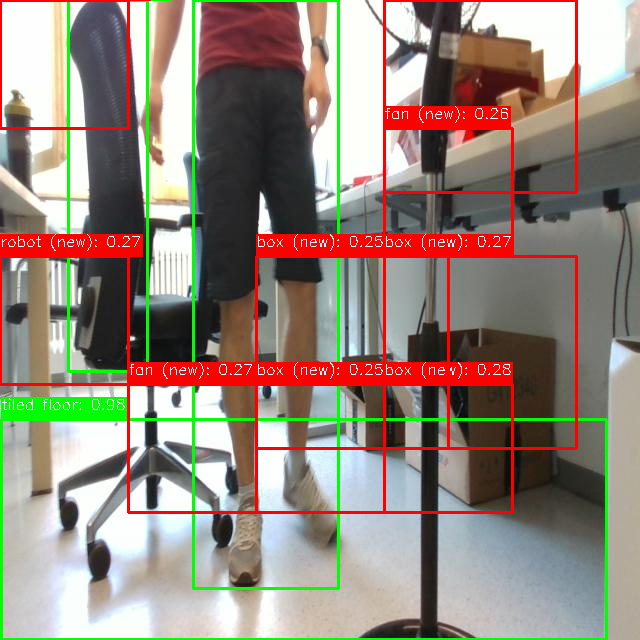

In [25]:
import torch
import numpy as np
from ultralytics import YOLO
import cv2
from PIL import Image
import os

class OVODDetector:
    def __init__(self, detector_weights, clip_model_name="ViT-B/32"):
        """Initialize OVOD Detector"""
        # Automatically detect available device
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {self.device}")

        # Load YOLO detector
        print(f"Loading YOLO model from {detector_weights}...")
        self.detector = YOLO(detector_weights)

        # Load CLIP for open-vocabulary classification
        print(f"Loading CLIP model {clip_model_name}...")
        try:
            self.clip_model, self.clip_preprocess = clip.load(clip_model_name, device=self.device)
            self.clip_model.eval()
            print(" CLIP loaded successfully")
        except Exception as e:
            print(f" Error loading CLIP: {e}")
            print("Trying reinstallation...")
            os.system("pip install git+https://github.com/openai/CLIP.git")
            import importlib
            importlib.reload(clip)
            self.clip_model, self.clip_preprocess = clip.load(clip_model_name, device=self.device)
            self.clip_model.eval()

        # YOLO known classes
        self.yolo_classes = [
            'backpack', 'banner', 'carton', 'chair', 'desk', 'door',
            'fire extinguisher', 'light bulb', 'miscellaneous', 'motorcycle',
            'person', 'pillar', 'staircase', 'step', 'table', 'tiled floor',
            'trash bin', 'tree', 'window', 'windows frame'
        ]

        # New classes (not in training set)
        self.unseen_classes = [
            'box', 'broom', 'cabinet', 'computer', 'fan', 'robot',
            'umbrella', 'laptop', 'book', 'bottle', 'keyboard', 'mouse'
        ]

        # Pre-compute CLIP text features
        print("Pre-computing CLIP text features...")
        self.yolo_text_features = self._encode_text_prompts(self.yolo_classes)
        self.unseen_text_features = self._encode_text_prompts(self.unseen_classes)

        print(f" YOLO can detect: {len(self.yolo_classes)} classes")
        print(f" OVOD added: {len(self.unseen_classes)} new classes")


    def _encode_text_prompts(self, class_names):
        """Encode class names to CLIP text features"""
        templates = [
            "a photo of a {}",
            "a picture of a {}",
            "an image of a {}",
            "a {} in the scene",
            "a {} object",
            "{}"
        ]

        text_inputs = []
        for cls in class_names:
            for template in templates:
                text_inputs.append(template.format(cls))

        text_tokens = clip.tokenize(text_inputs).to(self.device)

        with torch.no_grad():
            text_features = self.clip_model.encode_text(text_tokens)
            text_features = text_features.reshape(len(class_names), len(templates), -1)
            text_features = text_features.mean(dim=1)
            text_features /= text_features.norm(dim=-1, keepdim=True)

        return text_features

    def _non_maximum_suppression(self, detections, iou_threshold=0.5):

        if len(detections) <= 1:
            return detections

        # Sort by confidence
        detections = sorted(detections, key=lambda x: x['confidence'], reverse=True)

        filtered = []
        while detections:
            best = detections.pop(0)
            filtered.append(best)

            to_remove = []
            for i, det in enumerate(detections):
                iou = self._calculate_iou(best['bbox'], det['bbox'])
                if iou > iou_threshold:
                    to_remove.append(i)

            for idx in reversed(to_remove):
                detections.pop(idx)

        return filtered

    def _calculate_iou(self, box1, box2):

        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])

        if x2 <= x1 or y2 <= y1:
            return 0.0

        intersection = (x2 - x1) * (y2 - y1)
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
        union = area1 + area2 - intersection

        return intersection / union if union > 0 else 0

    def yolo_detection(self, image, confidence_thresh=0.3):
        """YOLO detection for known classes"""
        results = self.detector(image, verbose=False, conf=confidence_thresh)
        detections = []

        for result in results:
            if result.boxes is not None:
                for i, box in enumerate(result.boxes):
                    if box.conf.item() > confidence_thresh:
                        detections.append({
                            'bbox': box.xyxy[0].cpu().numpy().tolist(),
                            'confidence': box.conf.item(),
                            'class_id': int(box.cls.item()),
                            'class_name': self.yolo_classes[int(box.cls.item())],
                            'type': 'known',
                            'source': 'yolo'
                        })

        return detections

    def clip_based_detection(self, image, confidence_thresh=0.6, grid_size=128, max_proposals=100):
        """CLIP-based detection for new classes"""
        h, w = image.shape[:2]
        detections = []

        # Generate region proposals
        proposals = []
        for y in range(0, h - grid_size, grid_size):
            for x in range(0, w - grid_size, grid_size):
                for scale in [1, 1.5]:
                    size = int(grid_size * scale)
                    if x + size <= w and y + size <= h:
                        proposals.append([x, y, x + size, y + size])

        # Limit total proposals
        proposals = proposals[:max_proposals]

        # Batch processing
        batch_size = 16
        for i in range(0, len(proposals), batch_size):
            batch_proposals = proposals[i:i+batch_size]
            batch_images = []
            valid_indices = []

            for j, (x, y, x2, y2) in enumerate(batch_proposals):
                region = image[y:y2, x:x2]
                if region.size == 0:
                    continue

                pil_image = Image.fromarray(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
                preprocessed = self.clip_preprocess(pil_image).unsqueeze(0)
                batch_images.append(preprocessed)
                valid_indices.append(j)

            if not batch_images:
                continue

            # Batch inference
            batch_tensor = torch.cat(batch_images).to(self.device)
            with torch.no_grad():
                image_features = self.clip_model.encode_image(batch_tensor)
                image_features /= image_features.norm(dim=-1, keepdim=True)

                similarities = image_features @ self.unseen_text_features.T
                max_sims, best_indices = similarities.max(dim=1)

            # Collect results
            for k, (sim, idx) in enumerate(zip(max_sims, best_indices)):
                sim_value = sim.item()
                if sim_value > confidence_thresh:
                    original_idx = valid_indices[k]
                    x, y, x2, y2 = batch_proposals[original_idx]

                    # Calculate bounding box quality
                    area = (x2 - x) * (y2 - y)
                    img_area = h * w
                    area_ratio = area / img_area

                    if 0.01 < area_ratio < 0.5:
                        detections.append({
                            'bbox': [x, y, x2, y2],
                            'confidence': sim_value,
                            'class_id': idx.item(),
                            'class_name': self.unseen_classes[idx.item()],
                            'type': 'unseen',
                            'source': 'clip'
                        })

        # Apply NMS
        if len(detections) > 0:
            detections = self._non_maximum_suppression(detections, iou_threshold=0.3)

        return detections

    def predict_ovod(self, image_path, confidence_thresh=0.3, detect_unseen=True):

        # Read image
        if isinstance(image_path, str):
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Cannot read image: {image_path}")
        else:
            image = image_path

        all_detections = []

        # 1. YOLO detection for known classes

        yolo_detections = self.yolo_detection(image, confidence_thresh)
        print(f"YOLO found {len(yolo_detections)} known objects")

        # Filter YOLO results
        filtered_yolo = []
        h, w = image.shape[:2]
        img_area = h * w

        for det in yolo_detections:
            x1, y1, x2, y2 = det['bbox']
            area = (x2 - x1) * (y2 - y1)
            area_ratio = area / img_area

            if 0.002 < area_ratio < 0.8:
                filtered_yolo.append(det)

        print(f"Filtered YOLO detections: {len(filtered_yolo)}")
        all_detections.extend(filtered_yolo)

        # 2. CLIP detection for new classes
        if detect_unseen and len(self.unseen_classes) > 0:

            unseen_detections = self.clip_based_detection(
                image,
                confidence_thresh=0.25,

                grid_size=128,
                max_proposals=150
            )

            # Filter overlapping with YOLO detections
            final_unseen = []
            for unseen in unseen_detections:
                overlap = False
                for seen in all_detections:
                    iou = self._calculate_iou(unseen['bbox'], seen['bbox'])
                    if iou > 0.2:
                        overlap = True
                        break

                if not overlap:
                    final_unseen.append(unseen)

            print(f"CLIP found {len(final_unseen)} new objects")
            all_detections.extend(final_unseen)

        # 3. Final NMS
        if len(all_detections) > 1:
            all_detections = self._non_maximum_suppression(all_detections, iou_threshold=0.5)

        # 4. Limit total detections
        if len(all_detections) > 30:
            all_detections = sorted(all_detections, key=lambda x: x['confidence'], reverse=True)
            all_detections = all_detections[:30]
            print(f"Limiting total detections to 30")

        return all_detections

    def visualize_results(self, image_path, detections, output_path=None):
        """Visualize results"""
        if isinstance(image_path, str):
            image = cv2.imread(image_path)
        else:
            image = image_path.copy()

        # Color definitions
        colors = {
            'known': (0, 255, 0),    # Green - YOLO known classes
            'unseen': (0, 0, 255)    # Red - CLIP new classes
        }

        for det in detections:
            x1, y1, x2, y2 = map(int, det['bbox'])
            det_type = det.get('type', 'known')
            color = colors.get(det_type, (255, 255, 255))

            # Draw bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

            # Prepare label
            label = f"{det['class_name']}: {det['confidence']:.2f}"
            if det_type == 'unseen':
                label = f"{det['class_name']} (new): {det['confidence']:.2f}"

            # Draw label
            (text_width, text_height), baseline = cv2.getTextSize(
                label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)

            cv2.rectangle(image, (x1, y1 - text_height - baseline - 5),
                         (x1 + text_width, y1), color, -1)

            cv2.putText(image, label, (x1, y1 - baseline - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        if output_path:
            cv2.imwrite(output_path, image)
            print(f"Result saved to {output_path}")

        return image



if __name__ == "__main__":
    # Initialize detector
    detector = OVODDetector(
        detector_weights='/content/drive/MyDrive/yolo8/models/base_detector_seen_classes/weights/best.pt',
        clip_model_name="ViT-B/32"
    )

    # Create test image
    test_image = '/content/drive/MyDrive/ovod_ws/data/mu-cps-coco/test/images/rgb_mu_cps_01_0975_png.rf.7ccb039e26442fa1b4892bfb164c482f.jpg'

    # Run OVOD detection
    results = detector.predict_ovod(test_image, confidence_thresh=0.3)


    print(f"Total detections: {len(results)}")

    known_count = sum(1 for r in results if r['type'] == 'known')
    unseen_count = sum(1 for r in results if r['type'] == 'unseen')

    print(f"Known classes (YOLO): {known_count}")
    print(f"New classes (CLIP): {unseen_count}")

    if results:
        print(f"\n Detected objects:")
        for i, det in enumerate(results[:10]):  # Show only first 10
            source = "YOLO" if det['type'] == 'known' else "CLIP"
            print(f"{i+1}. {det['class_name']} ({source}): {det['confidence']:.2f}")

        # Visualize results
        vis_image = detector.visualize_results(
            test_image,
            results,
            output_path="/content/drive/MyDrive/yolo8/test_result.jpg"
        )



        from google.colab.patches import cv2_imshow
        print("\n Visualization result:")
        cv2_imshow(vis_image)

    else:
        print("No objects detected")